# Tutorial 2: Intermediate level
Using esinet to predict single time-frame sources of a sample ERP data set. 

This tutorial is based on an [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html)

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
import os

subjects_dir = mne.datasets.sample.data_path() + '\\subjects'
plot_params = dict(surface='white', hemi='both', verbose=0, subjects_dir=subjects_dir)
mne.set_config('SUBJECTS_DIR', subjects_dir)

# Load the data
Just as in the [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html) we have to load some sample data first

In [55]:
data_path = mne.datasets.sample.data_path()
raw_fname = os.path.join(data_path, 'MEG', 'sample',  
                    'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(raw_fname, verbose=0)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014', verbose=0)

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
# raw.info['bads'] = ['MEG 2443', 'EEG 053']  # no bad channels with EEG
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, eog=150e-6)  # , mag=4e-12

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=baseline, reject=reject,  # grad instead of meg
                    verbose=0)

fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif' 
fwd = mne.read_forward_solution(fname_fwd, verbose=0)


epochs_stripped = epochs.copy().load_data().pick_types(meg=True) # instead of meg=True
fwd = fwd.pick_channels(epochs_stripped.ch_names)
fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                                    use_cps=True, verbose=0)

## Visualize the sample data

In [56]:
epochs.average().plot(verbose=0)
epochs

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


Number of events,72
Events,aud_l: 72
Time range,-0.200 – 0.499 sec
Baseline,-0.200 – 0.000 sec


# Simulate Data
Artificial neural networks need training data to learn how to predict brain-electric activity (sources) given the M/EEG data. 

First, we calculate the signal to noise ratio (SNR) of our EEG data so we can adjust our simulations to it. 

In [57]:
target_snr = util.calc_snr_range(epochs, baseline_span=(-0.2, 0.0), data_span=(0.05, 0.2))
print(f'The target SNR ranges from {target_snr[0]:.2f} to {target_snr[1]:.2f}')

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
The target SNR ranges from 0.52 to 8.01


Next, we can perform the simulations with the packages default settings. Change n_samples to a smaller integer in case this cell runs for too long. Note, that for publication-ready inverse solutions you should increase the number of training samples to 100,000.

In [58]:
settings = dict(duration_of_trial=0.2, target_snr=target_snr[1])
n_samples = 10000
simulation = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation.simulate(n_samples=n_samples)

Simulate Source


  0%|          | 0/10000 [00:00<?, ?it/s]

Converting Source Data to mne.SourceEstimate object


  0%|          | 0/10000 [00:00<?, ?it/s]


Project sources to EEG...

Create EEG trials with noise...


  0%|          | 0/10000 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...


## Visualize the simulated data
Let's visualize the simulated data and see if it looks alright. You can change the idx to another integer to visualize a different sample

In [ ]:
%matplotlib qt
idx = 0

simulation.eeg_data[idx].average().plot_topomap([0.])
simulation.source_data.plot(**plot_params, initial_time=simulation.source_data.times[idx], time_viewer=False)

# Train the Neural Network
The Net class contains our neural network.

Using the simulations created above, we can train the neural network. This may take several minutes if you are using a CPU and less than a minute if you're using a GPU.

In [59]:
net = Net(fwd, verbose=1)  # Initialize the neural network object
net.fit(simulation)  # Train the net using our simulated eeg and source data.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_0 (Bidirectional)        (None, None, 200)         243200    
_________________________________________________________________
FC_0 (TimeDistributed)       (None, None, 100)         20100     
_________________________________________________________________
Drop_0 (Dropout)             (None, None, 100)         0         
_________________________________________________________________
FC_Out (TimeDistributed)     (None, None, 7498)        757298    
Total params: 1,020,598
Trainable params: 1,020,598
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
71/71 [==============================] - 104s 1s/step - loss: 0.0126 - val_loss: 0.0067
Epoch 2/50
71/71 [==============================] - 94s 1s/step - loss: 0.0067 - val_loss: 0.0066
Epoch 3/50
71/71 [===========================

KeyboardInterrupt: 

# Evaluate the ANN
The evaluation is a two-step procedure. 
1. Simulate some test data which the neural network has not seen yet. Unlike 
   the training data, this simulated data will also have a temporal dimension, 
   as indicated by the "duration_of_trial" parameter.

2. Perform predicions on this data and visually examine the results.

In [60]:
settings = dict(duration_of_trial=1, target_snr=target_snr[1], number_of_sources=(1, 10), extents=(2, 40),)
n_samples = 10
simulation_test = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation_test.simulate(n_samples=n_samples)


# Predict source from EEG
source_hat = net.predict(simulation_test)

Simulate Source


  0%|          | 0/10 [00:00<?, ?it/s]

Converting Source Data to mne.SourceEstimate object


  0%|          | 0/10 [00:00<?, ?it/s]


Project sources to EEG...

Create EEG trials with noise...


  0%|          | 0/10 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Shapes before scale: (10, 7498, 150), (10, 203, 150)


Visualize a sample

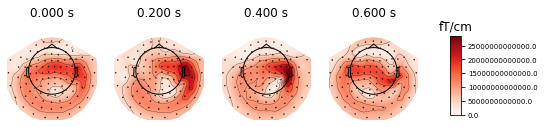

In [61]:
%matplotlib qt

# Ground Truth
idx = 1
source = simulation_test.source_data[idx]
# Plot simulated Source
a = source.plot(**plot_params)
a.add_text(0.1, 0.9, 'Gound Truth', 'title',
               font_size=14)
# Plot simulated EEG
evoked = simulation_test.eeg_data[idx].average()
evoked.plot()
evoked.plot_topomap([0.0, 0.2, 0.4, 0.6])

# Plot esinet prediction
b = source_hat[idx].plot(**plot_params)
b.add_text(0.1, 0.9, 'Prediction', 'title',
               font_size=14)

# Plot predicted EEG
evoked_hat = util.get_eeg_from_source(source_hat[idx], fwd, epochs_stripped.info, tmin=-0.2)
evoked_hat.plot()
evoked_hat.plot_topomap([0.0, 0.2, 0.4, 0.6])

# Estimate sources from real data
Using ANN

In [80]:
# gfp_esi = np.std(evoked_esi.pick('mag').data, axis=0)
# gfp_tru = np.std(epochs.pick(['mag']).average().data, axis=0)
# plt.figure()
# plt.subplot(211)
# plt.plot(gfp_esi, label='esi')
# plt.title('Esi')
# plt.subplot(212)
# plt.plot(gfp_tru, label='tru')
# plt.title('True')


gfp_esi = np.std(evoked_esi.pick('grad').data, axis=0)
gfp_tru = np.std(epochs.pick(['grad']).average().data, axis=0)
plt.figure()
plt.subplot(211)
plt.plot(gfp_esi, label='esi')
plt.title('Esi')
plt.subplot(212)
plt.plot(gfp_tru, label='tru')
plt.title('True')

Text(0.5, 1.0, 'True')

In [79]:
stc = net.predict(epochs.average())

solving
3.69319017454075e-14 1.320834158862534e-18
Shapes before scale: (1, 7498, 106), (1, 203, 106)


solving
3.69319017454075e-14 1.320834158862534e-18
Shapes before scale: (1, 7498, 106), (1, 203, 106)


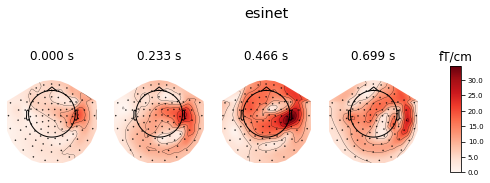

  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [7.97772084e-10 9.06494180e-10 3.45710794e-09]
Using control points [7.90605075e-10 8.92686013e-10 3.76648643e-09]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'
  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'
  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [9.16920623e-11 1.02058427e-10 7.12228670e-10]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [7.97772084e-10 9.06494180e-10 3.45710794e-09]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'
  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


In [81]:
# Predict Source
stc = net.predict(epochs.average())
# Plot Predicted Source
brain = stc.plot(**plot_params)
brain.add_text(0.1, 0.9, 'esinet on Auditory Data', 'title',
               font_size=14)
# Plot true EEG
epochs.load_data()

epochs.pick_types(meg=True).average().plot()
epochs.pick_types(meg=True).average().plot_topomap(title='True')

# Plot predicted EEG
evoked_esi = util.get_eeg_from_source(stc, fwd, epochs.pick_types(meg=True).info, tmin=0.)
evoked_esi.plot()
evoked_esi.plot_topomap(title='esinet')


...using eLORETA

In [ ]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=False)

inverse_operator = mne.minimum_norm.make_inverse_operator(
    evoked.info, fwd, noise_cov, loose='auto', depth=None, fixed=True, 
    verbose=False)
    
stc_elor, residual = mne.minimum_norm.apply_inverse(epochs.average(), inverse_operator, lambda2,
                              method=method, return_residual=True, verbose=False)
brain = np.abs(stc_elor).plot(**plot_params)
brain.add_text(0.1, 0.9, 'eLORETA on auditory data', 'title',
               font_size=14)
# Plot predicted EEG
epochs.load_data()
evoked_elor = util.get_eeg_from_source(stc_elor, fwd, epochs.pick_types(meg=True).info, tmin=0.)
evoked_elor.plot()
evoked_elor.plot_topomap(title='eLORETA')
